In [2]:
from os import listdir, makedirs
from os.path import exists, join
from pathlib import Path
from PIL import Image

import cv2
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import numpy as np
import onnx
import onnxruntime as ort
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

from rich.progress import Progress
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet, resnet18

In [3]:
test_tensor = torch.rand(1, 4)
print(test_tensor)
mask = torch.tensor([[1.0, 0.0, 1.0, 0.0]])

tensor([[0.1109, 0.3825, 0.6871, 0.4931]])


In [4]:
# Set test_tensor to -inf where mask is 0
test_tensor[mask != 1.0] = -torch.inf
print(test_tensor)

tensor([[0.1109,   -inf, 0.6871,   -inf]])


In [5]:
# class TestDataset(Dataset):
#     def __init__(self, data_dir, transform=None):
#         self.data_dir = data_dir
#         self.transform = transform

#         cls = {
#             "COVID": 0,
#             "Lung_Opacity": 1,
#             "Normal": 2,
#             "Viral Pneumonia": 3,
#         }
        
#         classes = listdir(data_dir)
#         self.images = []
#         self.labels = []
#         self.paths = []
#         for class_name in classes:
#             for image_name in listdir(f"{data_dir}/{class_name}"):
#                 self.images.append(f"{image_name}")
#                 self.labels.append(cls[class_name])
#                 self.paths.append(f"{data_dir}/{class_name}")

#     def __len__(self):
#         return len(self.images)
    
#     def __getitem__(self, idx):
#         image = plt.imread(f"{join(self.paths[idx], self.images[idx])}")
#         label = self.labels[idx]
        
#         if self.transform:
#             image = self.transform(image)
        
#         return image, label, self.images[idx]


def transform_image(shape: tuple[int, int] = (224, 224)) -> torch.Tensor:
    """Transform an image.

    Args:
    -----
        shape (tuple[int, int]): The shape of the image.

    Returns:
    --------
        v2.Compose: The transformation to apply to the image.
    """
    transform = v2.Compose(
        [
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Resize(shape, antialias=True),
            # v2.Normalize(mean=[122.358], std=[121.465]),
            # v2.Normalize(mean=0.5, std=0.5),
            # v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    return transform
    

class TestDataset(Dataset):
    def __init__(
        self,
        data_dir: str,
        shape_img=(224, 224),
        # shape_img=(128, 128),
        # shape_img=(256, 256),
        augment: bool = False,
        transform=None,
    ) -> None:
        super().__init__()
        self.data_dir = data_dir
        self.augment = augment

        self.transforms = transform

        self.data_df = pd.read_csv(self.data_dir)
        self.data_dir = "/".join(self.data_dir.split("/")[:-2])
        self.data_dir = self.data_dir.replace("csv_splits", "")
        self.data_dir = self.data_dir.replace("2_clients", "")

        # Shuffle the dataset
        self.data_df = self.data_df.sample(frac=1).reset_index(drop=True)
        # print(self.data_df.head())

        self.img_names = self.data_df["Image Index"].values
        self.paths = self.data_df["Path"].values

        # ------ COVID-19 -------
        self.paths = [path.removeprefix("datasets/") for path in self.paths]

        self.data_df.drop(
            columns=["Image Index", "Finding Labels", "Path"], inplace=True
        )
        # -----------------------

        # # --- NIH Chest X-ray ---
        # # print(self.data_df.head())
        # self.paths = [path.replace("extracted", "resized") for path in self.paths]
        # 
        # self.data_df.drop(
        #     columns=[
        #         # "Unnamed: 0.1",
        #         "Unnamed: 0",
        #         "Image Index",
        #         "Finding Labels",
        #         "Follow-up #",
        #         "Patient ID",
        #         "Patient Age",
        #         "Patient Gender",
        #         "View Position",
        #         "OriginalImagePixelSpacing[x",
        #         "y]",
        #         "Path",
        #     ],
        #     inplace=True,
        #     errors="ignore",
        # )
        # # -----------------------

        self.data_df = torch.tensor(self.data_df.values, dtype=torch.float32)

    def __len__(self):
        # return len(self.images)
        return len(self.data_df)

    def __getitem__(self, idx) -> tuple[torch.Tensor, torch.Tensor]:
        path = join(
            # self.data_dir,
            self.data_dir,
            # self.paths[idx].removeprefix("../dataset/"),
            self.paths[idx],
            self.img_names[idx],
        )

        img = Image.open(path).convert("L")
        img = self.transforms(img)

        label = self.data_df[idx]

        return img, label, self.img_names[idx]


def get_transforms():
    return v2.Compose([
        v2.ToImage(),
        # v2.Grayscale(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((224, 224), antialias=True),
    ])

def get_data_loader(data_dir, batch_size):
    # dataset = ImageFolder(data_dir, transform=get_transforms())
    dataset = TestDataset(data_dir, transform=get_transforms())
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

def get_device():
    # return torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return torch.device("cpu")

def load_model(model, model_path):
    device = get_device()
    try:
        model.load_state_dict(torch.load(model_path, map_location=device)["model"])
    except:
        model.load_state_dict(torch.load(model_path, map_location=device)["state_dict"])
    return model

In [6]:
def predict(onnx_model, data_loader):
    # num_labels = 15
    # threshold = 0.5
    # acc = MultilabelAccuracy(num_labels=num_labels, threshold=threshold, average="macro")
    # precision = MultilabelPrecision(num_labels=num_labels, threshold=threshold, average="macro")
    # f1 = MultilabelF1Score(num_labels=num_labels, threshold=threshold, average="macro")
    # predictions = []
    predictions = {"pred": [], "label": [], "img": []}
    # predictions = {"pred": [], "label": []}
    # predictions = {"accuracy": [], "precision": [], "f1": [], "img": []}
    # predictions = {"accuracy": [], "precision": [], "f1": []}
    with Progress() as progress:
        task = progress.add_task("[red]Predicting...", total=len(data_loader))
        for batch in data_loader:
            x, label, img = batch
            # x, label = batch

            input_name = onnx_model.get_inputs()[0].name
            y = onnx_model.run(None, {input_name: x.numpy()})[0]
            # y = onnx_model(x)
            # y = torch.tensor(y, dtype=torch.float32)
            
            # res = np.argmax(y, axis=1)
            # Multilabel classification
            # res = np.where(y > 0.5, 1, 0)
            # res = y
            # predictions["pred"].extend(res)
            predictions["pred"].extend(y)
            predictions["label"].extend(label.numpy())
            # predictions["accuracy"].extend(acc(y, label).numpy())
            # predictions["precision"].extend(precision(y, label).numpy())
            # predictions["f1"].extend(f1(y, label).numpy())
            predictions["img"].extend(img)
            progress.advance(task)
    return predictions

In [7]:
class LitCNN2d(pl.LightningModule):
    def __init__(
        self,
        input_shape: int,
        n_classes: int,
        lr: float,
        _logging: bool = False,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.lr = lr
        self._logging = _logging
        
        self.model = ResNet18(in_channels=input_shape, n_classes=self.n_classes)

    def forward(self, images):
        return self.model(images)

class ResNet18(nn.Module):
    def __init__(self, in_channels=3, in_features=16, n_classes=10):
        super(ResNet18, self).__init__()

        self.model = resnet18()

        self.model.conv1 = nn.Conv2d(
            in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )

        self.model.fc = nn.Linear(512, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # x = self.model(x)
        # return x
        return self.softmax(x)

In [8]:
# # model_path = "models/fl_aug_40/checkpoint.pt"
# # model_path = "models/local_aug_10/resnet18_e9.ckpt"
# # model_path = "models/epoch=39-step=42320.ckpt"
# # model_path = "models/resnet18/local_aug_pre_10/checkpoints/epoch=9-step=10580.ckpt"
# # model_path = "models/resnet18/fl_resnet18_4cl_e=40.pt"
# # model_path = "models/cnn/local_aug_40/checkpoints/epoch=39-step=42320.ckpt"
# # model_path = "models/cnn/local_aug_40/checkpoints/4_clients/client_2/last.ckpt"
# # model_path = "models/cnn/fl_aug_20/checkpoint.pt"
# # model_path = "models/cnn/fl/4_clients/aug_40/checkpoint.pt"
# # model_path = "models/cnn/fl/10_clients/aug_40_cluster/checkpoint_e=40_cl=10.pt"
# # model_path = "models/resnet18/model_round_3.pth"
# # model_path = "models/alexnet/centralized/last.ckpt"
# # model_path = "models/alexnet/fl/checkpoint_e=40.pt"
# model_path = "models/alexnet/4_clients/fl_alexnet_4cl_e=40.pt"
# # model = load_model(ResNet18(input_shape=1, n_classes=4, lr=0.001), model_path)
# # model = load_model(ResNet18(in_channels=1, n_classes=4), model_path)
# # model = ResNet18(in_channels=1, n_classes=4)
# # model = LitCNN2d(input_shape=1, n_classes=4, lr=0.001)

num_clients = 2
model_name = "unbalanced_missing_two_per_client_RS"

model_path = f"../models/resnet18/{num_clients}_clients/non_iid_data/{model_name}.pt"
model = LitCNN2d(input_shape=1, n_classes=4, lr=0.001)
state_dict = torch.load(model_path, map_location=get_device())
model.load_state_dict(state_dict["model"])
model.eval()

/tmp/ipykernel_88328/3632987397.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=get_device())


LitCNN2d(
  (model): ResNet18(
    (model): ResNet(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d

In [9]:
y = model.model.model(torch.randn(1, 1, 224, 224))
m = model.model.model

onnx_program = torch.onnx.dynamo_export(m, torch.randn(1, 1, 224, 224))
onnx_program.save(f"../models/resnet18/{num_clients}_clients/{model_name}.onnx")

/home/irina/miniconda3/envs/viz_tools/lib/python3.11/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/irina/miniconda3/envs/viz_tools/lib/python3.11/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/irina/miniconda3/envs/viz_tools/lib/python3.11/site-packages/torch/onnx/_internal/_exporter_legacy.py:116: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(
/home/irina/miniconda3/envs/viz_tools/lib/python3.11/site-packages/torch/onnx/_internal/fx/passes/readability.

In [10]:
# ONNX model inference
model_type = 100
# model_name = "2co-vp_model_best"

# model_path = f"models/{model_name}/{num_clients}_clients/federated_model_{model_type}.onnx"
# model_path = f"models/{model_name}/local/local_model_{model_type}.onnx"
# model_path = f"../models/resnet18/{num_clients}_clients/unbalanced_all_classes.onnx"
model_path = f"../models/resnet18/{num_clients}_clients/{model_name}.onnx"

# model = onnx.load(model_path)
ort_session = ort.InferenceSession(model_path)

In [11]:
# client_id = "8_clients"

# _model_path = f"models/{model_name}/{client_id}/checkpoint.pt"
# _model = LitCNN2d(input_shape=1, n_classes=4, lr=0.001)

# # To ONNX
# _weights = torch.load(_model_path)["model"]
# _model.load_state_dict(_weights)
# _model.eval()

# dummy_input = torch.randn(1, 1, 224, 224)
# torch.onnx.export(_model, dummy_input, f"models/{model_name}/{client_id}/federated_model_100.onnx", verbose=True)

In [12]:
# data_loader = get_data_loader("../dataset/splits/data_entry_2017_test.csv", 1)
data_loader = get_data_loader("../datasets/csv_splits/COVID-19_Radiography_Dataset_val.csv", 1)
# predictions = predict(model, data_loader)
predictions = predict(ort_session, data_loader)

Output()

In [13]:
_m = model.model.model
_m.eval()
_idx = 978
with torch.no_grad():
    print(predictions["pred"][_idx])
    print(predictions["label"][_idx])
    print(predictions["img"][_idx])
    print(_m(data_loader.dataset[_idx][0].unsqueeze(0)))

[11.813812 14.605009 14.658014 10.068472]
[1. 0. 0. 0.]
COVID-2342.png
tensor([[16.6326, 14.3024, 15.8855, 13.9182]])


In [14]:
softmax = nn.Softmax(dim=1)

preds = torch.argmax(softmax(torch.tensor(predictions["pred"])), dim=1).numpy()
labels = torch.argmax(torch.tensor(predictions["label"]), dim=1).numpy()
img_names = predictions["img"]

/tmp/ipykernel_88328/151661062.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  preds = torch.argmax(softmax(torch.tensor(predictions["pred"])), dim=1).numpy()


In [15]:
def gather_errors(predictions):
    # errors = {}
    # for pred, label, img in zip(predictions["pred"], predictions["label"], predictions["img"]):
    #     if pred != label:
    #         # errors.append((pred, label, img))
    #         errors[img] = (pred, label)
    preds = torch.argmax(softmax(torch.tensor(predictions["pred"])), dim=1).numpy()
    labels = torch.argmax(torch.tensor(predictions["label"]), dim=1).numpy()
    img_names = predictions["img"]

    return [(img, (pred, label)) for img, pred, label in zip(img_names, preds, labels) if pred != label]


def plot_errors(errors, data_dir, classes):
    save_dir = "datasets/error_images/"
    if not exists(save_dir):
        makedirs(save_dir)
    
    inv_classes = {v: k for k, v in classes.items()}
    for img, (pred, label) in errors.items():
        pth = join(data_dir, inv_classes[label], img)
        image = plt.imread(f"{pth}")
        plt.imshow(image, cmap="gray")
        plt.title(f"Predicted: {inv_classes[pred]}, Actual: {inv_classes[label]}")
        # plt.savefig(f"datasets/error_images/{img}")
        plt.xticks([])
        plt.yticks([])
        plt.axis("off")
        plt.grid(False)
        plt.savefig(f"{join(save_dir, img)}", bbox_inches="tight")

In [16]:
errors = gather_errors(predictions)
# plot_errors(errors, "datasets/splitted_dataset/test/", classes)

In [17]:
classes = {
    "COVID": 0,
    "Lung_Opacity": 1,
    "Normal": 2,
    "Viral Pneumonia": 3,
}

In [18]:
def confusion_matrix(predictions, classes):
    # matrix = torch.zeros(len(classes), len(classes), dtype=torch.int32)
    matrix = np.zeros((len(classes), len(classes)), dtype=np.int32)
    # for pred, label in predictions:
        # for p, l in zip(pred, label):
    for p, l in predictions:
            matrix[l, p] += 1

    df = pd.DataFrame(matrix, index=classes.keys(), columns=classes.keys())
    return df


def accuracy(confusion_matrix: pd.DataFrame):
    """
    Compute the overall accuracy and per-class accuracy from a confusion matrix DataFrame.
    
    Args:
    -----
        confusion_matrix (pd.DataFrame): A confusion matrix with true labels as rows and predicted labels as columns.
    
    Returns:
    --------
        tuple: (per_class, mean, std) where per_class is a dictionary of per-class accuracies, mean is the overall accuracy, and std is the standard deviation of the overall accuracy.
    """
    # Ensure the confusion matrix is a DataFrame
    if not isinstance(confusion_matrix, pd.DataFrame):
        raise ValueError("The confusion matrix must be a pandas DataFrame.")
    
    # Overall accuracy
    correct_predictions = confusion_matrix.values.diagonal().sum()
    total_predictions = confusion_matrix.values.sum()
    
    mean = np.round(correct_predictions / total_predictions if total_predictions > 0 else 0.0, 3)
    std = np.round(np.std(np.diag(confusion_matrix) / confusion_matrix.sum(axis=1)), 3)
    
    return mean, std


def sensitivity(confusion_matrix: pd.DataFrame):
    """
    Compute the overall sensitivity and per-class sensitivity from a confusion matrix DataFrame.
    
    Args:
    -----
        confusion_matrix (pd.DataFrame): A confusion matrix with true labels as rows and predicted labels as columns.
    
    Returns:
    --------
        tuple: (per_class, mean, std) where per_class is a dictionary of per-class sensitivities, mean is the overall sensitivity, and std is the standard deviation of the overall sensitivity.
    """
    # Ensure the confusion matrix is a DataFrame
    if not isinstance(confusion_matrix, pd.DataFrame):
        raise ValueError("The confusion matrix must be a pandas DataFrame.")
    
    # Overall sensitivity
    true_positives = np.diag(confusion_matrix)
    total_actual_positives = confusion_matrix.values.sum(axis=1)
    
    mean = np.round(np.mean(true_positives / total_actual_positives), 3)
    std = np.round(np.std(true_positives / total_actual_positives), 3)
    
    # Per-class sensitivity
    per_class = np.zeros(len(confusion_matrix))
    for i, label in enumerate(confusion_matrix.index):
        true_positive = confusion_matrix.iat[i, i]
        total_actual = confusion_matrix.loc[label].sum()
        per_class[i] = np.round(true_positive / total_actual if total_actual > 0 else 0.0, 3)
    
    return per_class, mean, std


def precision(confusion_matrix: pd.DataFrame):
    """
    Compute the overall precision and per-class precision from a confusion matrix DataFrame.
    
    Args:
    -----
        confusion_matrix (pd.DataFrame): A confusion matrix with true labels as rows and predicted labels as columns.
    
    Returns:
    --------
        tuple: (per_class, mean, std) where per_class is a dictionary of per-class precisions, mean is the overall precision, and std is the standard deviation of the overall precision.
    """
    # Ensure the confusion matrix is a DataFrame
    if not isinstance(confusion_matrix, pd.DataFrame):
        raise ValueError("The confusion matrix must be a pandas DataFrame.")
    
    # Overall precision
    true_positives = np.diag(confusion_matrix)
    total_predicted_positives = confusion_matrix.values.sum(axis=0)
    
    mean = np.round(np.mean(true_positives / total_predicted_positives), 3)
    std = np.round(np.std(true_positives / total_predicted_positives), 3)
    
    # Per-class precision
    per_class = np.zeros(len(confusion_matrix))
    for i, label in enumerate(confusion_matrix.index):
        true_positive = confusion_matrix.iat[i, i]
        total_predicted = confusion_matrix.iloc[:, i].sum()
        per_class[i] = np.round(true_positive / total_predicted if total_predicted > 0 else 0.0, 3)
    
    return per_class, mean, std


def f1_score(confusion_matrix: pd.DataFrame):
    """
    Compute the overall F1 score and per-class F1 score from a confusion matrix DataFrame.
    
    Args:
    -----
        confusion_matrix (pd.DataFrame): A confusion matrix with true labels as rows and predicted labels as columns.
    
    Returns:
    --------
        tuple: (per_class, mean, std) where per_class is a dictionary of per-class F1 scores, mean is the overall F1 score, and std is the standard deviation of the overall F1 score.
    """
    # Ensure the confusion matrix is a DataFrame
    if not isinstance(confusion_matrix, pd.DataFrame):
        raise ValueError("The confusion matrix must be a pandas DataFrame.")
    
    # Compute precision and recall
    def precision_recall(confusion_matrix):
        true_positives = np.diag(confusion_matrix)
        total_predicted_positives = confusion_matrix.values.sum(axis=0)
        precision = true_positives / total_predicted_positives
        total_actual_positives = confusion_matrix.values.sum(axis=1)
        recall = true_positives / total_actual_positives
        return precision, recall
    
    precision_values, recall_values = precision_recall(confusion_matrix)
    
    # Compute F1 score
    f1_scores = 2 * (precision_values * recall_values) / (precision_values + recall_values)
    
    # Overall F1 score
    mean = np.round(np.mean(f1_scores), 3)
    std = np.round(np.std(f1_scores), 3)
    
    # Per-class F1 score
    per_class = np.zeros(len(confusion_matrix))
    for i, label in enumerate(confusion_matrix.index):
        per_class[i] = np.round(f1_scores[i], 3)
    
    return per_class, mean, std


def boxplot(data, title, ylabel, filename):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=data)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.savefig(filename)
    plt.show()

In [19]:
# preds = np.array([[p, l] for p, l in zip(predictions["pred"], predictions["label"])])
pred_labels = np.stack((preds, labels), axis=1)
cm = confusion_matrix(pred_labels, classes)

# # Save predictions
# pred_labels_df = pd.DataFrame(pred_labels, columns=["Predicted", "Actual"])
# pred_labels_df["Image"] = img_names
# pred_labels_df.to_csv("../results/fl/2_clients/paper/predictions_unbalanced_all_classes.csv", index=False)

In [20]:
# # Save predictions
# save_dir = "datasets/output/predictions/"
# if not exists(save_dir):
#     makedirs(save_dir)
    
# preds_df = pd.DataFrame(preds, columns=["pred", "label"])
# preds_df.to_csv(f"{save_dir}/{model_path.split('/')[-1].split('.')[0]}.csv", index=False)

In [21]:
# y_true = np.array([predictions[i][1][0] for i in range(len(predictions))])
# y_pred = np.array([predictions[i][0][0] for i in range(len(predictions))])

# y_true = np.array([preds[i][1] for i in range(len(preds))])
# y_pred = np.array([preds[i][0] for i in range(len(preds))])

y_true = labels
y_pred = preds

In [22]:
classifications = classification_report(y_true, y_pred, target_names=classes.keys(), output_dict=True)

classifications_df = pd.DataFrame(classifications).transpose()
classifications_df

,precision,recall,f1-score,support
COVID,0.773842,0.786704,0.780220,361.000000
Lung_Opacity,0.624711,0.900166,0.737560,601.000000
Normal,0.856000,0.630029,0.725834,1019.000000
Viral Pneumonia,0.901515,0.888060,0.894737,134.000000
accuracy,0.749882,0.749882,0.749882,0.749882
macro avg,0.789017,0.801240,0.784588,2115.000000
weighted avg,0.779137,0.749882,0.749150,2115.000000


In [23]:
# mean_acc, std_acc = accuracy(cm)
mean_acc, std_acc = accuracy(cm)
sen, mean_sen, std_sen = sensitivity(cm)
pre, mean_pre, std_pre = precision(cm)
# dsc, mean_dice, std_dice = dice_score(cm)
f1, mean_f1, std_f1 = f1_score(cm)
print(f"Accuracy: {mean_acc:.3f} ± {std_acc:.2f} - (No per-class accuracy because the calculation of the TN takes into account the number of samples correctly classified of the other classes)")
print(f"Precision: {mean_pre:.3f} ± {std_pre:.2f} - {pre}")
print(f"Sensitivity: {mean_sen:.3f} ± {std_sen:.2f} - {sen}")
print(f"F1 score: {mean_f1:.3f} ± {std_f1:.2f} - {f1}")

Accuracy: 0.750 ± 0.11 - (No per-class accuracy because the calculation of the TN takes into account the number of samples correctly classified of the other classes)
Precision: 0.789 ± 0.10 - [0.774 0.625 0.856 0.902]
Sensitivity: 0.801 ± 0.11 - [0.787 0.9   0.63  0.888]
F1 score: 0.785 ± 0.07 - [0.78  0.738 0.726 0.895]


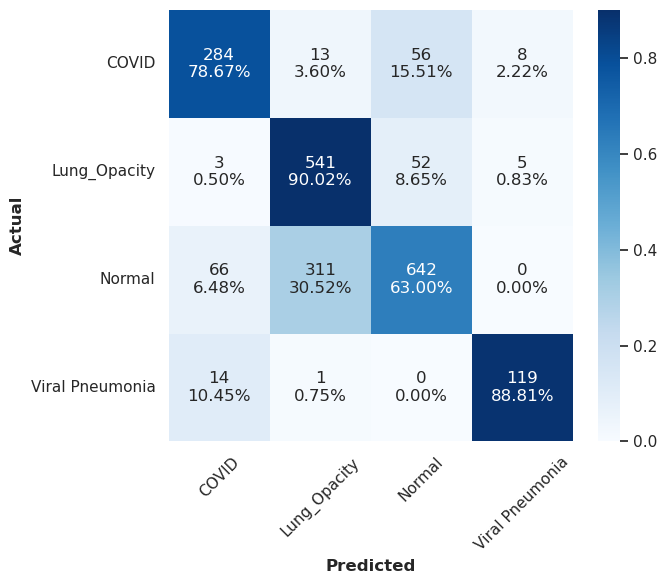

In [24]:
np_cm = cm.to_numpy()
normalized_cm = pd.DataFrame(np_cm / np_cm.sum(axis=1)[:, None], index=classes.keys(), columns=classes.keys())

sns.set(style="whitegrid")

labels = list(classes.keys())
# Take values of the absolute confusion matrix as annotations for the normalized confusion matrix
annotations = cm.to_numpy()
annotations = annotations.astype(str)
for i in range(len(annotations)):
    for j in range(len(annotations)):
        annotations[i, j] = f"{annotations[i, j]}\n{normalized_cm.loc[labels[i], labels[j]] * 100:.2f}%"
# Plot normalized confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(normalized_cm, annot=annotations, fmt="", cmap="Blues")
plt.xlabel("Predicted", fontsize=12, fontweight="bold")
plt.ylabel("Actual", fontsize=12, fontweight="bold")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
# plt.title(f"Normalized Confusion Matrix (centralized learning)", fontsize=15, fontweight="bold")
plt.tight_layout()
plt.show()
# Save the confusion matrix as SVG
# plt.savefig(f"../results/plots/2_clients/confusion_matrix_{model_name}.svg", format="svg")

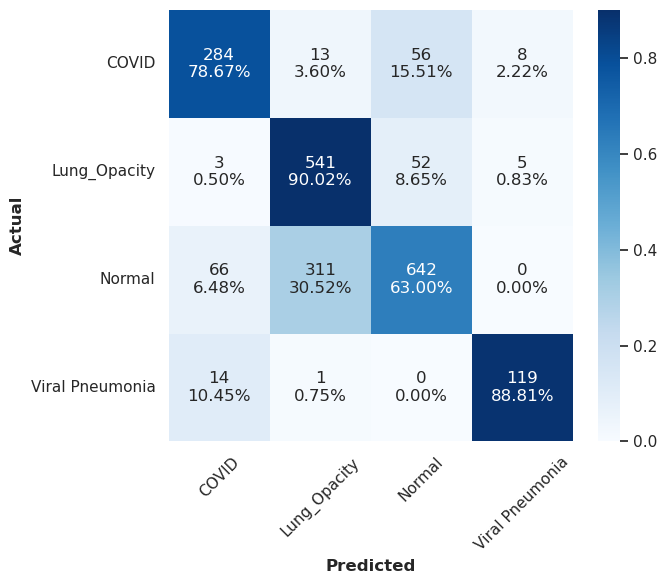

In [25]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(normalized_cm, annot=annotations, fmt="", cmap="Blues", ax=ax)
ax.set_xlabel("Predicted", fontsize=12, fontweight="bold")
ax.set_ylabel("Actual", fontsize=12, fontweight="bold")
ax.set_xticklabels(labels, rotation=45)
ax.set_yticklabels(labels, rotation=0)

plt.tight_layout()
plt.savefig(f"../results/plots/{num_clients}_clients/{model_name}.svg", format="svg")
plt.savefig(f"../results/plots/{num_clients}_clients/{model_name}.png", format="png")